<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/tune_similarity_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall gensim -y

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 2.8 kB/s 


In [ ]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311935 sha256=698b93e7ff497b2d2d85f98ed6089958f4b78bd34e9bbf4a664aed8f04061059
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
import hdbscan

In [ ]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
import pickle
import os

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

Full chords:

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y' -O input_seq.txt

--2021-11-09 13:56:23--  https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y
Resolving docs.google.com (docs.google.com)... 74.125.142.139, 74.125.142.101, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r9m2pq9m3h7nr5vq4qh1gchj1t8kp5l0/1636466175000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download [following]
--2021-11-09 13:56:24--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r9m2pq9m3h7nr5vq4qh1gchj1t8kp5l0/1636466175000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-4c-d

Simplified chords:

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_' -O input_seq.txt

--2021-11-09 13:56:24--  https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.113, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pehojbc1dqj31hvqac2c8gdpnp9h9is8/1636466175000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download [following]
--2021-11-09 13:56:25--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pehojbc1dqj31hvqac2c8gdpnp9h9is8/1636466175000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-10-4c-docs.googleusercontent.com (doc-10-4c-d

Meta Data:

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S' -O input_meta.csv

--2021-11-09 13:56:25--  https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.138, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5vmil14384h005q4l8v92i27v4km8qp/1636466175000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download [following]
--2021-11-09 13:56:26--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5vmil14384h005q4l8v92i27v4km8qp/1636466175000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-d

In [ ]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [ ]:
data = [line.split(' ') for line in lines]

### Meta Data

In [ ]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.columns

Index(['id', 'file_name', 'title', 'composer', 'year', 'year_truncated',
       'tonality', 'tune_key', 'tune_mode', 'structure', 'num_bars',
       'time_signature', 'cycle_fifths_order', 'style', 'musicbrainz_id',
       'wikidata_id', 'wikidata_allmusic', 'wiki_link', 'wikidata_description',
       'lyricist'],
      dtype='object')

In [ ]:
titles = meta.loc[:, ['id', 'title', 'tune_mode']].drop_duplicates()
titles.set_index('id', inplace=True)

In [ ]:
assert len(data) == len(titles)

In [ ]:
titles_dict = titles.to_dict()
index_to_title = titles_dict['title']
index_to_title[1170]

'These Foolish Things'

In [ ]:
title_to_index = {value: index for index, value in titles_to_index.items()}
title_to_index['These Foolish Things']

1170

# Chord N-Grams



In [ ]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [ ]:
def list_to_ngrams(data, n=2, sep='-'):
  out = []
  for row in data:
    out.append(ngrams(row, n, sep))

  return out

In [ ]:
data_ngrams = list_to_ngrams(data, 3)

In [ ]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

In [ ]:
df_chords = raw_chords_to_df(data_ngrams)
df_chords.head(10)

,chord,count
14,Dm7-G7-CM7,1628
76,G7-C-C,1471
136,A7-Dm7-G7,1427
900,C-C-C,1056
184,Dm7-G7-C6,996
86,G7-G7-C,967
135,Em7-A7-Dm7,828
862,D7-G7-C,760
182,A7-D7-G7,742
71,Am7-Dm7-G7,650


In [ ]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-11-09 13:56:34,498 : INFO : NumExpr defaulting to 2 threads.


# Word Embeddings

In [ ]:
from gensim.models import word2vec


### Train model

In [ ]:
train_data = data_ngrams
EMBED_SIZE = 100

In [ ]:
# train model
model = gensim.models.Word2Vec(train_data, 
                               vector_size=EMBED_SIZE,
                               min_count=5,
                               sample=1, #0.1,
                               sg=1,
                               window=2,
                               negative=2,
                               epochs=50,
                               workers=4,
                               #alpha=0.025,
                               )

2021-11-09 13:56:38,559 : INFO : collecting all words and their counts
2021-11-09 13:56:38,560 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-09 13:56:38,585 : INFO : collected 13442 word types from a corpus of 89538 raw words and 2046 sentences
2021-11-09 13:56:38,586 : INFO : Creating a fresh vocabulary
2021-11-09 13:56:38,605 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2440 unique words (18.152060705252193%% of original 13442, drops 11002)', 'datetime': '2021-11-09T13:56:38.605776', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-09 13:56:38,606 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 71559 word corpus (79.92025732091402%% of original 89538, drops 17979)', 'datetime': '2021-11-09T13:56:38.606954', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021,

In [ ]:
# summarize vocabulary
vocab = model.wv.index_to_key
print(vocab[:10])

['Dm7-G7-CM7', 'G7-C-C', 'A7-Dm7-G7', 'C-C-C', 'Dm7-G7-C6', 'G7-G7-C', 'Em7-A7-Dm7', 'D7-G7-C', 'A7-D7-G7', 'Am7-Dm7-G7']


In [ ]:
weights = model.syn1neg

In [ ]:
print(weights.shape)
vec_df = pd.DataFrame(weights, index=vocab)
vec_df.head()

(2440, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Dm7-G7-CM7,0.765491,-0.744193,-0.111878,0.138009,-0.077783,0.333702,-0.407242,-0.607488,0.437375,0.176947,0.325399,1.025343,0.252020,0.252298,-0.350425,0.640188,-0.152414,0.816507,-0.012020,0.424429,-0.537008,0.031791,-0.089310,0.197130,0.195394,-0.072062,0.396180,0.456345,0.384021,-0.008662,-0.660422,-0.166019,0.303969,0.159830,-0.399652,-0.190714,-0.411273,0.240600,0.335196,0.273566,...,-0.203404,-0.174582,0.400232,-0.129424,0.396105,-0.417995,0.170667,-0.381210,0.205275,-0.617542,0.293389,-0.626740,-0.854992,0.533439,-0.428933,-0.393193,-0.274280,0.234001,0.381990,0.049881,0.336993,-0.136153,-0.031615,-0.498153,-0.304723,-0.199429,0.466246,-0.242410,-0.482013,-0.652773,-0.381442,-0.045070,-0.212645,0.026026,-0.673224,-0.422000,-0.425622,0.633698,-0.479878,-0.265370
G7-C-C,0.489100,-0.355230,-0.152269,0.149548,0.058350,0.382958,0.299488,-1.012655,-0.331455,0.009584,0.404753,0.261400,0.247144,-0.233549,-0.399591,0.071842,0.240892,0.619347,-0.442474,0.387321,-0.518019,-0.322319,-0.115908,0.030733,-1.022285,0.168088,-0.095017,0.172085,0.905367,0.217221,-0.726373,-0.525292,0.400893,-0.086691,-0.436562,-0.316871,0.121176,0.745470,-0.401500,1.726766,...,-0.205626,-1.129377,0.351816,-0.342614,0.039844,-0.728348,0.215217,0.232182,0.227045,-0.490389,0.108596,-1.051453,-0.267869,0.650364,-0.984993,-0.504938,-0.221702,0.364363,0.169926,0.002782,-0.175567,0.420561,-0.230272,-0.381624,0.150145,0.062192,0.631839,-0.288512,-0.218321,-0.430448,0.094161,-0.428594,-0.662991,0.319906,-0.972034,-0.262391,-0.232377,0.389235,0.024576,-0.700854
A7-Dm7-G7,0.475928,-0.494895,-0.265140,0.128744,-0.092843,0.222839,-0.342061,-0.629737,0.144576,0.138413,0.319974,0.866800,0.238378,0.171644,-0.216965,0.456187,-0.151700,0.777887,-0.102980,0.146396,-0.346149,-0.040954,-0.189027,0.064421,-0.089310,-0.024697,0.413134,0.339214,0.327166,-0.007288,-0.462014,-0.088813,0.297553,0.266323,-0.399639,-0.140886,-0.173785,0.561133,0.210250,0.208969,...,-0.104734,-0.211301,0.466594,-0.226163,0.140567,-0.232542,0.290248,-0.142005,0.106047,-0.520656,0.348812,-0.686631,-0.740721,0.435007,-0.329814,-0.181511,-0.220267,0.267541,0.410884,0.078003,0.185901,-0.336785,-0.039517,-0.358806,-0.061781,-0.227247,0.374083,-0.083272,-0.254193,-0.520047,-0.401509,-0.102231,-0.269793,0.015637,-0.461803,-0.485923,-0.282002,0.592148,-0.201697,-0.167150
C-C-C,0.499059,-0.257343,-0.095850,0.103246,0.061350,0.438568,0.373876,-1.113862,-0.320416,-0.110482,0.442570,0.206230,0.315899,-0.186134,-0.363774,0.068161,0.275186,0.625360,-0.547730,0.516519,-0.617545,-0.431078,-0.104983,0.048899,-1.157273,0.227556,-0.008797,0.327037,0.977374,0.316130,-0.778941,-0.618070,0.473172,-0.072215,-0.600918,-0.352071,0.117898,0.775503,-0.466257,2.009112,...,-0.268335,-1.272259,0.418041,-0.356038,0.056878,-0.881003,0.287239,0.291752,0.250602,-0.528487,0.184953,-1.152683,-0.204112,0.789696,-1.095706,-0.613271,-0.296668,0.473623,0.034713,-0.042237,-0.279599,0.472301,-0.211550,-0.417482,0.114758,0.104595,0.710822,-0.363249,-0.152463,-0.562079,0.092160,-0.478405,-0.694531,0.348836,-1.047311,-0.302949,-0.266263,0.458949,-0.010441,-0.784510
Dm7-G7-C6,0.672288,-0.576517,-0.073038,0.293983,-0.048194,0.356864,-0.446742,-0.578808,0.232456,0.081808,0.201902,0.856834,0.320562,0.345202,-0.225309,0.625249,-0.325458,0.860636,-0.086626,0.337023,-0.201830,-0.048659,-0.220676,0.215592,0.047982,-0.036535,0.567428,0.391696,0.356403,0.145924,-0.577505,-0.024271,0.412739,0.382356,-0.312964,-0.123683,-0.280364,0.441437,0.262619,0.302540,...,-0.184672,-0.036326,0.485472,-0.396615,0.204928,-0.295977,0.358808,-0.136390,0.054288,-0.447666,0.359112,-0.779311,-0.803833,0.574367,-0.273175,-0.235685,-0.199893,0.279634,0.460771,0.129176,0.084771,-0.315963,-0.049481,-0.479613,-0.238414,-0.274662,0.374960,-0.100288,-0

### Visualize the embedding weight for each chord ngram


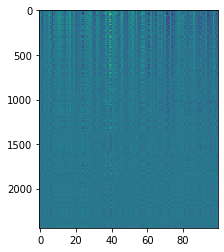

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(weights, interpolation='nearest')
ax.set_aspect(0.05)

In [ ]:
vocab_set = set(vocab)
model_dict = dict(zip(vocab, weights))

## Calculate Embeddings for Tunes

For all ngrams in a tune, average the corresponding ngram embedding vectors to determine the tune embedding vector.

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
  vocabulary = vocab_set

  features = []
  for tune in corpus:
    features.append(average_word_vectors(tune, 
                                         model, 
                                         vocabulary, 
                                         num_features)
    )

  return np.array(features)

In [ ]:
# get document level embeddings
corpus = data_ngrams
num_features = EMBED_SIZE

ft_doc_features = averaged_word_vectorizer(corpus=corpus, 
                                           model=model_dict,
                                           num_features=num_features)

df_features = pd.DataFrame(ft_doc_features)

In [ ]:
df_features.shape

(2046, 100)

In [ ]:
df_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.185470,-0.204706,-0.007506,0.066084,-0.047158,0.078328,-0.133004,-0.111654,0.161238,0.040315,0.065800,0.326803,0.106992,0.107374,-0.055727,0.223021,-0.100236,0.241205,0.028487,0.144529,-0.085990,0.005275,-0.018077,0.041041,0.119708,-0.042522,0.181322,0.168000,0.064218,-0.030457,-0.142515,0.029265,0.067334,0.104669,-0.108752,-0.102701,-0.153112,0.039051,0.164180,-0.053067,...,-0.032609,0.121825,0.128508,-0.021174,0.159252,-0.087370,0.078604,-0.143957,0.005152,-0.159546,0.087522,-0.137732,-0.253244,0.152026,-0.036511,-0.075466,-0.066220,0.120521,0.155295,0.053244,0.186439,-0.084552,0.025782,-0.177899,-0.106770,-0.106528,0.114891,-0.018826,-0.161724,-0.220573,-0.130804,0.008210,-0.041102,0.040700,-0.120958,-0.146264,-0.126501,0.208469,-0.167763,-0.010461
1,0.458147,-0.324942,-0.077221,0.070081,-0.147868,0.260691,-0.204948,-0.309833,0.176597,0.072320,0.097176,0.581772,0.167059,0.124368,-0.191997,0.340363,-0.142263,0.424792,-0.004819,0.159133,-0.227785,0.000121,-0.045152,0.144112,0.201484,0.032484,0.248487,0.216046,0.117938,0.044040,-0.439290,-0.077306,0.090319,0.142232,-0.201527,-0.093436,-0.229665,0.164863,0.146426,0.068625,...,-0.133069,-0.005910,0.146973,-0.169566,0.163596,-0.220699,0.135546,-0.212634,0.037048,-0.256363,0.186792,-0.281746,-0.423910,0.283055,-0.182488,-0.207057,-0.014019,0.106610,0.181836,0.033115,0.135497,-0.101290,-0.001990,-0.370995,-0.089408,-0.164812,0.229252,-0.089927,-0.232004,-0.289046,-0.212521,-0.011834,-0.077174,-0.054070,-0.297812,-0.274156,-0.259461,0.341846,-0.271251,-0.063639
2,0.328563,-0.156767,-0.061460,-0.013112,-0.111059,0.230181,-0.102976,-0.202235,0.147795,0.073790,0.065862,0.439292,0.063371,0.053006,-0.101159,0.186102,-0.123776,0.246815,-0.024153,0.121544,-0.145222,0.020923,-0.054956,0.140136,0.209457,0.048300,0.163454,0.100163,0.076423,0.066081,-0.314053,-0.019742,-0.038328,0.027936,-0.087062,-0.109112,-0.251867,0.059912,0.076885,0.022201,...,-0.062168,0.061789,0.061094,-0.020680,0.185577,-0.224292,0.098586,-0.193364,-0.026991,-0.081869,0.189960,-0.103696,-0.266680,0.196640,-0.123774,-0.130052,0.029597,0.041529,0.126061,0.031155,0.185973,-0.116016,0.018933,-0.279218,-0.103473,-0.174979,0.189593,-0.089895,-0.140463,-0.154840,-0.126326,0.017864,0.007165,-0.014777,-0.201237,-0.161524,-0.183388,0.174740,-0.217565,-0.017887
3,0.283989,-0.277355,-0.076131,0.176175,-0.031114,0.183021,0.113363,-0.583241,-0.180623,0.083567,0.208408,0.281080,0.165638,-0.021165,-0.215916,0.139786,0.061779,0.387522,-0.203478,0.116570,-0.123733,-0.030441,-0.104422,-0.008771,-0.431696,0.066937,0.050030,0.132124,0.396812,0.092635,-0.338652,-0.220121,0.226375,0.063675,-0.244075,-0.162963,0.033495,0.384764,-0.141581,0.719304,...,-0.077686,-0.460419,0.265967,-0.153496,0.028667,-0.376499,0.115848,0.057407,0.134294,-0.288673,0.088517,-0.591038,-0.247331,0.326049,-0.412895,-0.234140,-0.122735,0.203194,0.156134,0.090359,0.027869,0.066867,-0.151060,-0.204776,0.074465,-0.016672,0.297950,-0.059852,-0.157358,-0.276115,-0.087435,-0.115325,-0.276056,0.133164,-0.445698,-0.206632,-0.151160,0.295588,-0.018101,-0.322303
4,0.100598,-0.084316,-0.067365,0.007189,0.024915,0.044979,-0.035941,-0.205245,-0.023237,-0.039559,0.206475,0.129685,0.052719,0.035312,0.019451,0.115880,0.009432,0.110927,-0.067788,0.045062,-0.130345,-0.008650,-0.078488,0.048970,-0.043620,0.040536,0.120335,0.139353,0.109801,0.001966,-0.063363,-0.090994,0.094763,0.014124,-0.094655,-0.058560,-0.059195,0.055664,-0.045383,0.169591,...,-0.030786,-0.076130,0.111250,-0.008149,-0.022768,-0.090989,0.124512,-0.001606,0.060382,-0.038451,0.075988,-0.176570,-0.100888,0.060599,-0.088872,-0.024252,-0.002515,0.046243,0.055353,0.007659,0.121742,-0.074402,-0.033216,-0.043376,0.055220,0.031729,0.088015,-0.059250,-0.047286,-0.037896,-0.142851,-0.053152,-0.0

#### Visualize the average embedding vectors for each tune


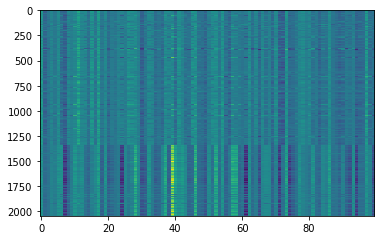

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_features, interpolation='nearest')
ax.set_aspect(0.03)

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(ft_doc_features)

cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, 
                              columns=['ClusterLabel'])
print(f"Number of Clusters: {max(ap.labels_)}")


Number of Clusters: 42


#### T-SNE of tunes based on Embeddings

In [ ]:
assert(len(titles) == len(ft_doc_features))

In [ ]:
tsne = TSNE(n_components=2, 
            random_state=0,
            perplexity = 70,
            learning_rate=100.0,
            #n_iter_without_progress=200,
            n_iter=5000
            )
#np.set_printoptions(suppress=True)
T = tsne.fit_transform(ft_doc_features)

In [ ]:
projected = pd.DataFrame(T)
projected['tune'] = titles['title']
#projected['cluster'] = df_cluster['ClusterLabel'].astype(str)
projected['mode'] = meta['tune_mode']

fig = px.scatter(
    projected, 
    x=0, y=1,
    color='mode',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

### Cluster the T-SNE Result

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
clusterer.fit(T)

clusterer.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
clust_proj = pd.DataFrame(T)
clust_proj['tune'] = titles['title']
clust_proj['cluster'] = clusterer.labels_.astype(str)
clust_proj['mode'] = titles['tune_mode']

fig = px.scatter(
    clust_proj, 
    x=0, y=1,
    color='cluster',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

In [ ]:
clust_proj

,0,1,tune,cluster,mode
0,3.598697,-21.877361,26-2,0,major
1,27.720404,-17.242655,500 Miles High,0,minor
2,10.165466,-26.154507,502 Blues,0,minor
3,-12.253464,13.026691,52nd Street Theme,1,major
4,-7.083214,-14.493589,9.20 Special,0,major
...,...,...,...,...,...
2041,-24.220846,20.397738,You're Foolin' Someone,1,major
2042,10.256585,-1.811585,You're Lucky To Me,0,major
2043,-15.618068,11.939542,You're Nobody Till Somebody Loves You,1,major
2044,-32.105576,32.728054,Your Feet's Too Big,1,major


#### Histograms for ngrams for each Cluster

In [ ]:
def plot_cluster_histograms(df, cluster, top_n=45):
  tune_ind = df.query(f'cluster=="{cluster}"').index
  tune_ind

  # filter the tunes
  tune_chords = [ data_ngrams[i] for i in tune_ind ]

  # flatten the filtered tunes
  tune_chords = [item for tune in tune_chords for item in tune]

  counts = Counter(tune_chords)
  df_chords = pd.DataFrame(counts.items(),
                      columns=['chord_ngram', 'count']).sort_values(by='count', ascending=False)

  df_chords = pd.DataFrame.from_dict(df_chords[:top_n])
  df_chords.sort_values(by=['count'], ascending=False, inplace=True)

  fig = px.bar(df_chords, x='chord_ngram', y='count', log_y=True, title=f"Cluster {cluster}")
  fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
  fig.show()

In [ ]:
plot_cluster_histograms(clust_proj, cluster=0)

In [ ]:
plot_cluster_histograms(clust_proj, cluster=1)

In [ ]:
plot_cluster_histograms(clust_proj, cluster=2)

### Similarity Tree

In [ ]:
import networkx as nx
from collections import deque

def sim_tree(model, word, top_n, max_dist):

    graph = nx.Graph()
    graph.add_node(word, dist=0)

    to_visit = deque([word])
    while len(to_visit) > 0:
        source = to_visit.popleft() # visit next node
        dist = graph.nodes[source]['dist']+1

        if dist <= max_dist: # discover new nodes
            for target, sim in model.most_similar(source, topn=top_n):
                if target not in graph:
                    to_visit.append(target)
                    graph.add_node(target, dist=dist)
                    graph.add_edge(source, target, sim=sim, dist=dist)
    return graph

In [ ]:
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

def plot_tree(graph, node_size=1000, font_size=8):

    pos = graphviz_layout(graph, prog='twopi', root=list(graph.nodes)[0])

    colors = [graph.nodes[n]['dist'] for n in graph] # colorize by distance
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=colors,
                           cmap='Set1', alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=font_size)

    for (n1, n2, sim) in graph.edges(data='sim'):
         nx.draw_networkx_edges(graph, pos, [(n1, n2)], width=sim, alpha=0.2)
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.show()


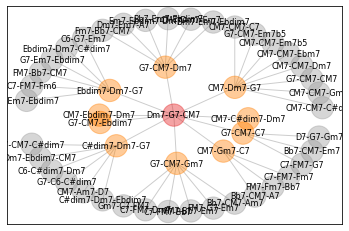

In [ ]:
graph = sim_tree(model.wv, 'Dm7-G7-CM7', top_n=10, max_dist=2)
plot_tree(graph, node_size=500, font_size=8)

## Cosine Similarity between Tunes

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([ft_doc_features[0]], [ft_doc_features[1]])

array([[0.93119183]])

In [ ]:
df_cos = pd.DataFrame(cosine_similarity(ft_doc_features),
                      columns=titles['title'],
                      index=titles['title'])
df_cos

title,26-2,500 Miles High,502 Blues,52nd Street Theme,9.20 Special,A Ballad,A Beautiful Friendship,A Blossom Fell,A Certain Smile,A Child Is Born,A Felicidade,A Fine Romance,A Flower Is A Lovesome Thing,A Foggy Day,A Ghost Of A Chance,A Kiss To Build A Dream On,A Little Tear,A Lovely Way To Spend An Evening,A Night In Tunisia,A Nightingale Sang In Berkeley Square,A Pretty Girl Is Like A Melody,A Sleepin' Bee,A Smooth One,A Sound For Sore Ears,A Sunday Kind Of Love,A Taste Of Honey,A Time For Love,A Tisket A Tasket,A Weaver Of Dreams,A Wonderful Day Like Today,Ablution,Ac-Cent-Tchu-Ate The Positive,Across The Alley From The Alamo,Adam's Apple,Affirmation,"African Queen, The",Afro Blue,Afro Centric,After You've Gone,After You,...,When Your Hair Has Turned To Silver,Whenever You're Lonesome,Where He Leads Me,Where The Saviour Leads Me,While We Danced At The Mardi Gras,Whispering,"White Cliffs Of Dover, The","White Sport Coat And A Pink Carnation, A",Who's Sorry Now,Why Don't You Go Down To New Orleans,Wild Man Blues,Willie The Weeper,Winin' Boy Blues,Wish Me Luck As You Wave Me Goodbye,"Without You For An Inspiration, Dear",Wolverine Blues,Wooden Heart,Working Man Blues,Wrap Your Troubles In Dreams,Yama Yama Man,Yearning,Yellow Dog Blues,"Yes Sir, That's My Baby",Yes! We Have No Bananas,You Always Hurt The One You Love,You Are My Sunshine,You Belong To Me,You Broke Your Promise,You Can Depend On Me,You Meet The Nicest People In Your Dreams,You Must Have Been A Beautiful Baby,"You Tell Me Your Dreams, I'll Tell You Mine",You Were Only Fooling,You're A Real Sweetheart,You're Driving Me Crazy,You're Foolin' Someone,You're Lucky To Me,You're Nobody Till Somebody Loves You,Your Feet's Too Big,Zing Went The Strings Of My Heart
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26-2,1.000000,0.931192,0.900199,0.484188,0.597861,0.967504,0.930265,0.841840,0.918214,0.735363,0.936828,0.923072,0.754487,0.943604,0.954722,0.930721,0.876147,0.946708,0.736010,0.962385,0.877450,0.864369,0.577448,0.400263,0.953392,0.801354,0.882685,0.929691,0.933432,0.924299,0.960036,0.925975,0.869137,0.384750,0.802590,0.501625,0.341566,0.858281,0.919712,0.935197,...,0.277232,0.245805,0.240105,0.259828,0.288143,0.210335,0.181189,0.227775,0.343357,0.251513,0.202710,0.247932,0.243231,0.285566,0.304971,0.226636,0.271120,0.266319,0.235574,0.275038,0.241604,0.216149,0.261630,0.247021,0.165875,0.259089,0.143956,0.222114,0.939117,0.276520,0.265241,0.232990,0.218698,0.216105,0.179635,0.238626,0.684595,0.319018,0.243199,0.156131
500 Miles High,0.931192,1.000000,0.951343,0.634941,0.684919,0.970082,0.971924,0.918544,0.968665,0.873916,0.991277,0.964786,0.854711,0.972676,0.977387,0.942122,0.952403,0.980446,0.852275,0.983216,0.952907,0.946659,0.577871,0.587071,0.975219,0.915822,0.963455,0.967497,0.990016,0.967337,0.981602,0.957856,0.935153,0.468568,0.893668,0.585512,0.419630,0.883342,0.970734,0.978716,...,0.463185,0.432228,0.425713,0.445456,0.470161,0.393227,0.365570,0.414519,0.520753,0.438339,0.405703,0.455503,0.431867,0.474979,0.480882,0.409884,0.457260,0.449706,0.428104,0.459166,0.427129,0.401341,0.449061,0.429916,0.349472,0.442991,0.329921,0.414172,0.969711,0.461194,0.449552,0.420795,0.409174,0.402847,0.368970,0.423825,0.819820,0.495655,0.430068,0.351428
502 Blues,0.900199,0.951343,1.000000,0.512515,0.606166,0.910954,0.890234,0.804775,0.893139,0.856025,0.965414,0.878379,0.746937,0.892574,0.906372,0.895680,0.850772,0.915716,0.833311,0.930693,0.865149,0.856235,0.545268,0.483064,0.900699,0.877820,0.979605,0.880616,0.956013,0.878120,0.926797,0.867562,0.854930,0.412410,0.882869,0.600929,0.507187,0.846280,0.887599,0.917527,...,0.350574,0.313384,0.314332,0.336735,0.358389,0.276217,0.249557,0.302944,0.396917,0.329751,0.301366,0.370290,0.318161,0.367346,0.360506,0.297513,0.347957,0.336864,0.315808,0.348466,0.316422,0.291225,0.339364,0.315195,0.239908,0.333059,0.219402,0.305472,0.883983,0.348968,0.335603,0.306108,0.298359,0.293674,0.257337,0.308574

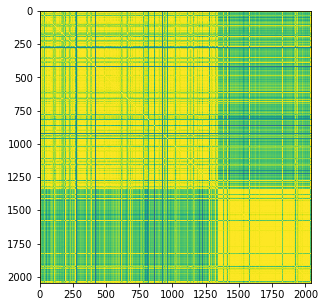

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_cos, interpolation='nearest')
ax.set_aspect(1)

In [ ]:
def get_similar_tunes(df, threshold = 0.9):
  # display tunes that have a cos_sim value bigger than the threshold

  # create a series of tunes containing a list of similar tunes for each tune
  cols = df.columns
  bt = df.apply(lambda x: x > threshold)
  result = bt.apply(lambda x: list(cols[x.values]), axis=1)

  # print the result
  tuneA = []
  tuneB = []
  cos_val = []

  for idx, val in tqdm(result.iteritems()):
    # if the tune is similar to other tunes
    if len(val) <= 1:
      continue
    #print(f'{idx}')
    for tune in val:
      if tune != idx:
        #print(f'\t{df.loc[idx][tune]:.3f} - {tune}')
        tuneA.append(idx)
        tuneB.append(tune)
        cos_val.append(df.loc[idx][tune])

  df_result = pd.DataFrame(list(zip(tuneA,
                                    tuneB,
                                    cos_val)),
                           columns=['tuneA', 'tuneB', 'cos_val']
                           )
  df_result.sort_values(['tuneA', 'cos_val'], ascending=[True, False], inplace=True)
  return df_result

In [ ]:
# threshold for the cosinus similarity value to display
COS_THRES = 0.8

In [ ]:
nn = 100 # limit the number of tunes to speed up

df_result_chords = get_similar_tunes(df_cos.iloc[0:nn,0:nn], 
                                     threshold=COS_THRES)

100it [00:00, 138.22it/s]


In [ ]:
df_result_chords['tuneA'].unique()

array(['26-2', '500 Miles High', '502 Blues', '52nd Street Theme',
       '9.20 Special', 'A Ballad', 'A Beautiful Friendship',
       'A Blossom Fell', 'A Certain Smile', 'A Child Is Born',
       'A Felicidade', 'A Fine Romance', 'A Flower Is A Lovesome Thing',
       'A Foggy Day', 'A Ghost Of A Chance', 'A Kiss To Build A Dream On',
       'A Little Tear', 'A Lovely Way To Spend An Evening',
       'A Night In Tunisia', 'A Nightingale Sang In Berkeley Square',
       'A Pretty Girl Is Like A Melody', "A Sleepin' Bee",
       'A Sound For Sore Ears', 'A Sunday Kind Of Love',
       'A Taste Of Honey', 'A Time For Love', 'A Tisket A Tasket',
       'A Weaver Of Dreams', 'A Wonderful Day Like Today', 'Ablution',
       'Ac-Cent-Tchu-Ate The Positive', 'Across The Alley From The Alamo',
       "Adam's Apple", 'Affirmation', 'Afro Centric', 'After You',
       "After You've Gone", 'Afternoon In Paris', 'Again',
       'Agua De Beber', 'Ahmid-6', "Ain't Misbehavin'", "Ain't She Sweet",
 

In [ ]:
df_result_chords.query('tuneA == "Autumn Leaves"').reset_index()

,index,tuneA,tuneB,cos_val
0,6644,Autumn Leaves,Alone Together,0.992895
1,6608,Autumn Leaves,A Time For Love,0.979649
2,6589,Autumn Leaves,502 Blues,0.972256
3,6588,Autumn Leaves,500 Miles High,0.971374
4,6595,Autumn Leaves,A Felicidade,0.971043
...,...,...,...,...
77,6616,Autumn Leaves,Afro Centric,0.853048
78,6657,Autumn Leaves,April,0.852984
79,6659,Autumn Leaves,Armando's Rhumba,0.851932
80,6592,Autumn Leaves,A Blossom Fell,0.849007


## Assessing the Model

To assess our new model, we’ll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we’re pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we’ve likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we’ll keep track of the second ranks for a comparison of less similar documents.

### Hyperparameters for Word2Vec

In [ ]:
!mkdir models_word2vec

In [ ]:
model_path = './models_word2vec'
model_prefix = 'autos'

param_grid = {'w2v': {'variant': ['cbow', 'sg'], 'window': [2, 3, 4, 10]},
              'ft': {'variant': ['sg'], 'window': [5]}}
size = 100

for algo, params in param_grid.items():
    for variant in params['variant']:
        sg = 1 if variant == 'sg' else 0
        for window in params['window']:
            if algo == 'w2v':
                model = gensim.models.Word2Vec(data_ngrams, vector_size=size, window=window, sg=sg, epochs=5)
            else:
                model = gensim.models.FastText(data_ngrams, vector_size=size, window=window, sg=sg, epochs=5)

            file_name = f"{model_path}/{model_prefix}_{algo}_{variant}_{window}"
            model.wv.save_word2vec_format(file_name + '.bin', binary=True)



2021-11-09 13:59:55,542 : INFO : collecting all words and their counts
2021-11-09 13:59:55,544 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-09 13:59:55,565 : INFO : collected 13442 word types from a corpus of 89538 raw words and 2046 sentences
2021-11-09 13:59:55,567 : INFO : Creating a fresh vocabulary
2021-11-09 13:59:55,586 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2440 unique words (18.152060705252193%% of original 13442, drops 11002)', 'datetime': '2021-11-09T13:59:55.586515', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-09 13:59:55,588 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 71559 word corpus (79.92025732091402%% of original 89538, drops 17979)', 'datetime': '2021-11-09T13:59:55.588163', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021,

### Evaluating the different Models


In [ ]:
from gensim.models import KeyedVectors

names = ['autos_w2v_cbow_2', 'autos_w2v_sg_2',
         'autos_w2v_cbow_3', 'autos_w2v_sg_3',
         'autos_w2v_cbow_4', 'autos_w2v_sg_4',
         'autos_w2v_cbow_10', 'autos_w2v_sg_10',
         ]
models = {}

for name in names:
    file_name = f"{model_path}/{name}.bin"
    models[name] = KeyedVectors.load_word2vec_format(file_name, binary=True)

2021-11-09 14:00:15,464 : INFO : loading projection weights from ./models_word2vec/autos_w2v_cbow_2.bin
2021-11-09 14:00:15,498 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (2440, 100) matrix of type float32 from ./models_word2vec/autos_w2v_cbow_2.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-11-09T14:00:15.498292', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}
2021-11-09 14:00:15,500 : INFO : loading projection weights from ./models_word2vec/autos_w2v_sg_2.bin
2021-11-09 14:00:15,528 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (2440, 100) matrix of type float32 from ./models_word2vec/autos_w2v_sg_2.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-11-09T14:00:15.528828', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bi

In [ ]:
models

{'autos_w2v_cbow_10': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e88768710>,
 'autos_w2v_cbow_2': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e886bd850>,
 'autos_w2v_cbow_3': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e7cd3efd0>,
 'autos_w2v_cbow_4': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e7cfa8690>,
 'autos_w2v_sg_10': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e86add110>,
 'autos_w2v_sg_2': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e886bde90>,
 'autos_w2v_sg_3': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e7cd3ef90>,
 'autos_w2v_sg_4': <gensim.models.keyedvectors.KeyedVectors at 0x7f2e7cfa86d0>}

In [ ]:
def compare_models(models, **kwargs):

    df = pd.DataFrame()
    for name, model in models:
        df[name] = [f"{word} {score:.3f}"
                    for word, score in model.most_similar(**kwargs)]
    df.index = df.index + 1 # let row index start at 1
    return df

In [ ]:
compare_models([(n, models[n]) for n in names], positive='CM7-Dm7-G7', topn=10)

,autos_w2v_cbow_2,autos_w2v_sg_2,autos_w2v_cbow_3,autos_w2v_sg_3,autos_w2v_cbow_4,autos_w2v_sg_4,autos_w2v_cbow_10,autos_w2v_sg_10
1,CM7-CM7-Dm7 0.978,CM7-Dm7-Ebdim7 0.937,G7-CM7-Dm7 0.985,CM7-Dm7-Ebdim7 0.937,G7-CM7-Dm7 0.985,CM7-Dm7-Ebdim7 0.920,G7-CM7-Dm7 0.981,G7-CM7-Dm7 0.863
2,G7-CM7-Dm7 0.972,CM7-CM7-Dm7 0.928,G7-CM7-CM7 0.979,F#dim7-CM7-Dm7 0.916,G7-CM7-CM7 0.982,G7-CM7-Cm7 0.897,G7-CM7-CM7 0.980,CM7-C-C6 0.856
3,G7-CM7-CM7 0.971,G7-CM7-Cm7 0.922,Dm7-G7-CM7 0.975,G7-CM7-Cm7 0.914,CM7-CM7-Dm7 0.968,G7-CM7-Dm7 0.895,G7-CM7-G7 0.978,CM7-CM7-Dm7 0.840
4,Dm7-G7-CM7 0.963,G#M7-Dm7-G7 0.921,CM7-CM7-Dm7 0.973,CM7-CM7-Dm7 0.911,Dm7-G7-CM7 0.965,C6-CM7-Dm7 0.890,CM7-G7-CM7 0.975,F#dim7-CM7-Dm7 0.829
5,CM7-Dm7-Em7 0.937,CM7-Dm7-Em7 0.918,G7-CM7-C#dim7 0.959,G#M7-Dm7-G7 0.904,G7-CM7-C#dim7 0.954,CM7-Dm7-Ebdim 0.886,Dm7-Em7-Ebdim7 0.974,Dm7-Ebdim-Em7 0.812
6,G7-CM7-FM7 0.936,CM7-CM7-Em7b5 0.917,CM7-Dm7-Em7 0.958,G7-CM7-Dm7 0.897,CM7-C#dim7-Dm7 0.951,CM7-CM7-Dm7 0.885,F#dim7-CM7-Dm7 0.963,C6-CM7-Dm7 0.812
7,G7-CM7-C#dim7 0.934,G7-CM7-B7 0.916,CM7-C#dim7-Dm7 0.954,G7-CM7-Fm7 0.895,CM7-Dm7-Em7 0.949,CM7-C-C6 0.882,CM7-C#dim7-Dm7 0.962,Dm7-Em7-G7 0.807
8,CM7-C#dim7-Dm7 0.924,Dm7b5-G7-CM7 0.912,G7-CM7-Ebdim7 0.952,CM7-Dm7-Ebdim 0.893,G7-CM7-Em7b5 0.947,G7-CM7-F#m7 0.882,CM7-FM7-Em7 0.960,EM7-EM7-EM7 0.795
9,C#dim7-Dm7-G7 0.924,EbM7-Dm7-G7 0.904,G7-CM7-C7 0.948,CM7-CM7-Em7b5 0.891,G7-CM7-G7 0.939,F#dim7-CM7-Dm7 0.878,G7-Ebm7-G#7 0.960,Dm7-G7-Dm7b5 0.795
10,G7-CM7-F7 0.924,Dm7-Em7-Dm7 0.902,C#dim7-Dm7-G7 0.947,Dm7-Em7-Ebdim7 0.891,C#dim7-Dm7-G7 0.939,CM7-D7-Dm7 0.877,F7-Em7-Ebdim7 0.958,Dm7-Em7-Ebdim7 0.794


# Doc2Vec Embeddings

## Read and Tag Data

In [ ]:
import smart_open

def read_corpus(fname, ngram_size, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = ngrams(line.split(), ngram_size, '-')
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

## Doc2Vec Hyperparameters

In [ ]:
!rm -R models_doc2vec
!rm -R traindata_doc2vec

rm: cannot remove 'models_doc2vec': No such file or directory
rm: cannot remove 'traindata_doc2vec': No such file or directory


In [ ]:
!mkdir models_doc2vec
!mkdir traindata_doc2vec

In [ ]:
model_path = './models_doc2vec'
model_prefix = 'autos'
data_path = './traindata_doc2vec'

param_grid = {'d2v': {'variant': ['pv-dm', 
                                  'pv-dbow'], 
                      'window': [2, 3, 4, 10],
                      'sample': [0.1],
                      'ngrams': [1, 2, 3, 4],
                     }
              }
size = 100
epochs = 50

for algo, params in param_grid.items():
    for variant in params['variant']:
        dm = 1 if variant == 'pv-dm' else 0
        for ngram_size in params['ngrams']:
            
            # prepare data with the provided ngram size
            train_corpus = list(read_corpus(path_to_file, ngram_size=ngram_size))

            # evaluate different window sizes
            for window in params['window']:

                # evaluate the effect of different sample sizes
                for sample in params['sample']:

                    # calculate the model
                    if algo == 'd2v':
                        model = gensim.models.doc2vec.Doc2Vec(vector_size=size, 
                                                              window=window,
                                                              dm = dm,
                                                              min_count=5, 
                                                              sample = sample, # threshold for configuring which higher-frequency words are randomly downsampled
                                                              epochs=epochs,
                                                              )
                        model.build_vocab(train_corpus)
                        model.train(train_corpus, 
                                    total_examples=model.corpus_count, 
                                    epochs=model.epochs)

                    else:
                        model = gensim.models.FastText(data_ngrams, vector_size=size, window=window, sg=sg, epochs=50)

                    file_name = f"{model_path}/{model_prefix}_{algo}_{variant}_{ngram_size}_{window}_{sample}"
                    model.save(file_name + '.model')

                    file_name = f"{data_path}/{model_prefix}_{algo}_{variant}_{ngram_size}_{window}_{sample}"
                    with open(file_name + '.train', 'wb') as f:
                          # Pickle the 'data' dictionary using the highest protocol available.
                          pickle.dump(train_corpus, f, pickle.HIGHEST_PROTOCOL)

Streaming output truncated to the last 5000 lines.
2021-11-09 14:02:48,742 : INFO : EPOCH - 49 : training on 89538 raw words (73605 effective words) took 0.3s, 228026 effective words/s
2021-11-09 14:02:49,046 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-09 14:02:49,061 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-09 14:02:49,064 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-09 14:02:49,069 : INFO : EPOCH - 50 : training on 89538 raw words (73605 effective words) took 0.3s, 233124 effective words/s
2021-11-09 14:02:49,071 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4476900 raw words (3680250 effective words) took 16.0s, 230568 effective words/s', 'datetime': '2021-11-09T14:02:49.071119', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-11-09 14:02:49,072 : INFO : Doc2Ve

In [ ]:
from gensim.models import KeyedVectors

from os import listdir
from os.path import isfile, join

names = [f for f in listdir(model_path) if isfile(join(model_path, f))]
print(names)
models = {}

for name in names:
    file_name = f"{model_path}/{name}"
    print(file_name)
    models[name] = Doc2Vec.load(file_name)

2021-11-09 14:07:12,694 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_1_2_0.1.model
2021-11-09 14:07:12,698 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_1_2_0.1.model.dv.* with mmap=None
2021-11-09 14:07:12,704 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_1_2_0.1.model.wv.* with mmap=None
2021-11-09 14:07:12,707 : INFO : setting ignored attribute cum_table to None
2021-11-09 14:07:12,712 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_1_2_0.1.model', 'datetime': '2021-11-09T14:07:12.712584', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 14:07:12,715 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_4_4_0.1.model
2021-11-09 14:07:12,723 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_4_4_0.1.model.dv.* 

['autos_d2v_pv-dbow_1_2_0.1.model', 'autos_d2v_pv-dbow_4_4_0.1.model', 'autos_d2v_pv-dbow_2_3_0.1.model', 'autos_d2v_pv-dm_3_4_0.1.model', 'autos_d2v_pv-dbow_4_3_0.1.model', 'autos_d2v_pv-dm_1_2_0.1.model', 'autos_d2v_pv-dm_2_2_0.1.model', 'autos_d2v_pv-dm_3_2_0.1.model', 'autos_d2v_pv-dbow_2_2_0.1.model', 'autos_d2v_pv-dbow_1_3_0.1.model', 'autos_d2v_pv-dbow_3_3_0.1.model', 'autos_d2v_pv-dm_1_4_0.1.model', 'autos_d2v_pv-dm_4_2_0.1.model', 'autos_d2v_pv-dbow_4_10_0.1.model', 'autos_d2v_pv-dbow_4_2_0.1.model', 'autos_d2v_pv-dbow_1_4_0.1.model', 'autos_d2v_pv-dbow_2_10_0.1.model', 'autos_d2v_pv-dbow_3_10_0.1.model', 'autos_d2v_pv-dm_2_10_0.1.model', 'autos_d2v_pv-dm_2_4_0.1.model', 'autos_d2v_pv-dbow_3_4_0.1.model', 'autos_d2v_pv-dm_4_4_0.1.model', 'autos_d2v_pv-dm_2_3_0.1.model', 'autos_d2v_pv-dm_4_3_0.1.model', 'autos_d2v_pv-dm_4_10_0.1.model', 'autos_d2v_pv-dm_3_3_0.1.model', 'autos_d2v_pv-dm_3_10_0.1.model', 'autos_d2v_pv-dbow_3_2_0.1.model', 'autos_d2v_pv-dbow_2_4_0.1.model', 'autos

2021-11-09 14:07:12,898 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_4_3_0.1.model', 'datetime': '2021-11-09T14:07:12.897978', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 14:07:12,901 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_1_2_0.1.model
2021-11-09 14:07:12,905 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_1_2_0.1.model.dv.* with mmap=None
2021-11-09 14:07:12,907 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_1_2_0.1.model.wv.* with mmap=None
2021-11-09 14:07:12,910 : INFO : setting ignored attribute cum_table to None
2021-11-09 14:07:12,915 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_1_2_0.1.model', 'datetime': '2021-11-09T14:07:12.915639', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n

./models_doc2vec/autos_d2v_pv-dm_1_2_0.1.model
./models_doc2vec/autos_d2v_pv-dm_2_2_0.1.model
./models_doc2vec/autos_d2v_pv-dm_3_2_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_2_2_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_1_3_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_3_3_0.1.model


2021-11-09 14:07:13,110 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_1_4_0.1.model
2021-11-09 14:07:13,116 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_1_4_0.1.model.dv.* with mmap=None
2021-11-09 14:07:13,117 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_1_4_0.1.model.wv.* with mmap=None
2021-11-09 14:07:13,123 : INFO : setting ignored attribute cum_table to None
2021-11-09 14:07:13,128 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_1_4_0.1.model', 'datetime': '2021-11-09T14:07:13.128122', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 14:07:13,130 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_4_2_0.1.model
2021-11-09 14:07:13,135 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_4_2_0.1.model.dv.* with mmap=No

./models_doc2vec/autos_d2v_pv-dm_1_4_0.1.model
./models_doc2vec/autos_d2v_pv-dm_4_2_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_4_10_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_4_2_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_1_4_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_2_10_0.1.model


2021-11-09 14:07:13,312 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_2_10_0.1.model.wv.* with mmap=None
2021-11-09 14:07:13,314 : INFO : setting ignored attribute cum_table to None
2021-11-09 14:07:13,345 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_2_10_0.1.model', 'datetime': '2021-11-09T14:07:13.345802', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 14:07:13,349 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_3_10_0.1.model
2021-11-09 14:07:13,355 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_3_10_0.1.model.dv.* with mmap=None
2021-11-09 14:07:13,356 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_3_10_0.1.model.wv.* with mmap=None
2021-11-09 14:07:13,358 : INFO : setting ignored attribute cum_table to None
2021-11-09 14

./models_doc2vec/autos_d2v_pv-dbow_3_10_0.1.model
./models_doc2vec/autos_d2v_pv-dm_2_10_0.1.model
./models_doc2vec/autos_d2v_pv-dm_2_4_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_3_4_0.1.model
./models_doc2vec/autos_d2v_pv-dm_4_4_0.1.model


2021-11-09 14:07:13,584 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_4_4_0.1.model', 'datetime': '2021-11-09T14:07:13.584764', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 14:07:13,587 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_2_3_0.1.model
2021-11-09 14:07:13,594 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_2_3_0.1.model.dv.* with mmap=None
2021-11-09 14:07:13,595 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_2_3_0.1.model.wv.* with mmap=None
2021-11-09 14:07:13,599 : INFO : setting ignored attribute cum_table to None
2021-11-09 14:07:13,619 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_2_3_0.1.model', 'datetime': '2021-11-09T14:07:13.619472', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[G

./models_doc2vec/autos_d2v_pv-dm_2_3_0.1.model
./models_doc2vec/autos_d2v_pv-dm_4_3_0.1.model
./models_doc2vec/autos_d2v_pv-dm_4_10_0.1.model
./models_doc2vec/autos_d2v_pv-dm_3_3_0.1.model


2021-11-09 14:07:13,790 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_3_10_0.1.model
2021-11-09 14:07:13,798 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_3_10_0.1.model.dv.* with mmap=None
2021-11-09 14:07:13,800 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_3_10_0.1.model.wv.* with mmap=None
2021-11-09 14:07:13,803 : INFO : setting ignored attribute cum_table to None
2021-11-09 14:07:13,839 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_3_10_0.1.model', 'datetime': '2021-11-09T14:07:13.839411', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 14:07:13,845 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_3_2_0.1.model
2021-11-09 14:07:13,851 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_3_2_0.1.model.dv.* with

./models_doc2vec/autos_d2v_pv-dm_3_10_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_3_2_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_2_4_0.1.model
./models_doc2vec/autos_d2v_pv-dbow_1_10_0.1.model
./models_doc2vec/autos_d2v_pv-dm_1_10_0.1.model
./models_doc2vec/autos_d2v_pv-dm_1_3_0.1.model


In [ ]:
names = [f for f in listdir(data_path) if isfile(join(data_path, f))]
print(names)
data = {}

for name in names:
    file_name = f"{data_path}/{name}"
    print(file_name)
    with open(file_name, 'rb') as f:
        data[name] = pickle.load(f)

['autos_d2v_pv-dm_2_3_0.1.train', 'autos_d2v_pv-dbow_2_4_0.1.train', 'autos_d2v_pv-dbow_4_3_0.1.train', 'autos_d2v_pv-dbow_4_4_0.1.train', 'autos_d2v_pv-dm_3_2_0.1.train', 'autos_d2v_pv-dm_2_4_0.1.train', 'autos_d2v_pv-dbow_3_3_0.1.train', 'autos_d2v_pv-dm_3_10_0.1.train', 'autos_d2v_pv-dbow_2_3_0.1.train', 'autos_d2v_pv-dm_1_2_0.1.train', 'autos_d2v_pv-dbow_1_2_0.1.train', 'autos_d2v_pv-dbow_3_2_0.1.train', 'autos_d2v_pv-dm_2_2_0.1.train', 'autos_d2v_pv-dm_1_10_0.1.train', 'autos_d2v_pv-dbow_1_4_0.1.train', 'autos_d2v_pv-dm_3_4_0.1.train', 'autos_d2v_pv-dm_3_3_0.1.train', 'autos_d2v_pv-dm_4_4_0.1.train', 'autos_d2v_pv-dbow_4_2_0.1.train', 'autos_d2v_pv-dbow_2_2_0.1.train', 'autos_d2v_pv-dbow_4_10_0.1.train', 'autos_d2v_pv-dbow_3_4_0.1.train', 'autos_d2v_pv-dm_4_3_0.1.train', 'autos_d2v_pv-dbow_3_10_0.1.train', 'autos_d2v_pv-dbow_2_10_0.1.train', 'autos_d2v_pv-dm_4_2_0.1.train', 'autos_d2v_pv-dm_1_3_0.1.train', 'autos_d2v_pv-dbow_1_3_0.1.train', 'autos_d2v_pv-dm_1_4_0.1.train', 'autos_

In [ ]:
for name, m in models.items():
  print(m)

Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w3,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w3,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w3,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc

In [ ]:
def compare_doc_models(models, **kwargs):

    passes = 3

    df = pd.DataFrame()
    names = []
    scores = []
    runs = []

    for p in range(passes):
      print(f"\n*** Run {p}")
      for name, model in models.items():
        ranks = []
        second_ranks = []
        similarities = []

        print(name)

        # load the training corpus data
        train_name = os.path.splitext(name)[0] + '.train'
        train_corpus = data[train_name]
        print(train_corpus[:5])

        # use the model to infer the similarity for a tune
        for doc_id in range(len(train_corpus)):
            inferred_vector = model.infer_vector(train_corpus[doc_id].words)
            sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
            similarities.append(sims)
            rank = [docid for docid, sim in sims].index(doc_id)
            ranks.append(rank)

            second_ranks.append(sims[1])

        counter = Counter(ranks)
        print(counter)

        tunes_sim = counter[0]
        tunes_not_sim = len(train_corpus) - counter[0]
        score = 100 * tunes_not_sim/(tunes_sim+tunes_not_sim)

        print(f"\tTunes similar to themselves in first place: {tunes_sim}")
        print(f"\tTunes not similar in first place: {tunes_not_sim}")
        print(f"\t% of tunes not similar to themselves in first place: {score:.2f}%")

        names.append(name)
        scores.append(score)
        runs.append(p)
      
    df = pd.DataFrame({'name': names, 
                        'score': scores,
                        'pass': runs
                      })

    return df

In [ ]:
df_score = compare_doc_models(models)


*** Run 0
autos_d2v_pv-dbow_1_2_0.1.model
[TaggedDocument(words=['CM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'Gm7', 'C7', 'FM7', 'G#7', 'C#M7', 'E7', 'Am7', 'D7', 'Dm7', 'G7', 'CM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'Gm7', 'C7', 'FM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'CM7', 'Gm7', 'C7', 'Bm7', 'E7', 'AM7', 'C7', 'FM7', 'Bbm7', 'Eb7', 'G#M7', 'Dm7', 'G7', 'CM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'Gm7', 'C7', 'FM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'CM7'], tags=[0]), TaggedDocument(words=['Am7', 'Am7', 'Cm7', 'Cm7', 'EbM7', 'EbM7', 'Em7b5', 'A7', 'Dm7', 'Dm7', 'Bm7b5', 'Bm7b5', 'Bbm7', 'Bbm7', 'Fm7', 'Fm7', 'E7', 'E7', 'Fm7', 'Fm7', 'C#M7', 'C#M7', 'Fm7', 'Fm7', 'C#M7', 'C#M7'], tags=[1]), TaggedDocument(words=['Am7', 'C#M7', 'Bm7b5', 'E7', 'Am7', 'C#M7', 'Bm7b5', 'E7', 'Cm7', 'F7', 'BbM7', 'G#m7', 'C#7', 'F#m7b5', 'B7', 'EM7', 'EM7', 'E7', 'Am7', 'C#M7', 'Bm7b5', 'E7', 'Am7', 'C#M7', 'Bm7b5', 'E7', 'Cm7', 'F7', 'BbM7', 'G#m7', 'C#7', 'F#m7b5', 'B7', 'Em7', 'Em7'], tags=[2]), TaggedDoc

In [ ]:
pd.pivot_table(df_score, index = 'name', values = 'score', columns='pass')

pass,0,1,2
name,,,
autos_d2v_pv-dbow_1_10_0.1.model,4.985337,4.740958,4.985337
autos_d2v_pv-dbow_1_2_0.1.model,4.838710,4.936461,4.936461
autos_d2v_pv-dbow_1_3_0.1.model,4.838710,4.447703,4.594330
autos_d2v_pv-dbow_1_4_0.1.model,4.594330,4.740958,4.545455
autos_d2v_pv-dbow_2_10_0.1.model,2.785924,2.737048,2.737048
autos_d2v_pv-dbow_2_2_0.1.model,3.323558,2.688172,2.639296
autos_d2v_pv-dbow_2_3_0.1.model,2.981427,2.932551,2.688172
autos_d2v_pv-dbow_2_4_0.1.model,2.737048,2.688172,2.834800
autos_d2v_pv-dbow_3_10_0.1.model,2.639296,3.079179,2.883675


In [ ]:
import time
t = time.localtime()
timestamp = time.strftime('%Y%m%d_%H%M%S', t)
print(timestamp)

20211109_164459


In [ ]:
score_filename = f'score_{timestamp}.csv'
df_score.to_csv(score_filename)

In [ ]:
 !zip -r models.zip models_doc2vec/ 

  adding: models_doc2vec/ (stored 0%)
  adding: models_doc2vec/autos_d2v_pv-dbow_1_2_0.1.model (deflated 8%)
  adding: models_doc2vec/autos_d2v_pv-dbow_4_4_0.1.model (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dbow_2_3_0.1.model (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_3_4_0.1.model (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dbow_4_3_0.1.model (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dm_1_2_0.1.model (deflated 7%)
  adding: models_doc2vec/autos_d2v_pv-dm_2_2_0.1.model (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_3_2_0.1.model (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dbow_2_2_0.1.model (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dbow_1_3_0.1.model (deflated 8%)
  adding: models_doc2vec/autos_d2v_pv-dbow_3_3_0.1.model (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dm_1_4_0.1.model (deflated 7%)
  adding: models_doc2vec/autos_d2v_pv-dm_4_2_0.1.model (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dbow_4_10_

In [ ]:
from google.colab import files
files.download("models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(score_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Assess the best Model

In [ ]:
best_model = 'autos_d2v_pv-dbow_3_4_0.1'

In [ ]:
model = models[f"{best_model}.model"]

#### Assess self-similarity

In [ ]:
ranks = []
second_ranks = []
similarities = []

train_corpus = data[f"{best_model}.train"]

for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    similarities.append(sims)
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [ ]:
import collections

counter = collections.Counter(ranks)
print(counter)

tunes_sim = counter[0]
tunes_not_sim = len(train_corpus) - counter[0]

print()
print(f"Tunes similar to themselves in first place: {tunes_sim}")
print(f"Tunes not similar in first place: {tunes_not_sim}")
print(f"% of tunes not similar to themselves in first place: {100 * tunes_not_sim/(tunes_sim + tunes_not_sim):.2f}%")

Counter({0: 1993, 1: 34, 3: 5, 2: 3, 1910: 1, 1742: 1, 1102: 1, 7: 1, 1109: 1, 4: 1, 2032: 1, 65: 1, 6: 1, 227: 1, 816: 1})

Tunes similar to themselves in first place: 1993
Tunes not similar in first place: 53
% of tunes not similar to themselves in first place: 2.59%


In [ ]:
print('Tunes that are similar to other tunes before they are similar to themselves:')
for tune_index, value in enumerate(ranks):
  if value > 0:
    print(f"'{titles.iloc[tune_index, 0]}': {value}")

Tunes that are similar to other tunes before they are similar to themselves:
'Anthropology': 2
'Arise, Her Eyes': 1910
'Bags' Groove': 1
'Basin Street Blues': 1
'Bessie's Blues': 1
'Billie's Bounce': 4
'Birth Of The Blues, The': 1
'Blue Monk': 1
'Blue Skies': 1
'Blue Sphere': 2
'Bye Bye Blues': 1
'C'est Si Bon': 1
'Cyclic Episode': 1742
'Dig': 1
'Equinox': 1
'Get Happy': 1
'Honeysuckle Rose': 1
'I Can't Give You Anything But Love': 1
'Lazy River': 1
'Moose The Mooche': 2
'No Moe': 3
'Now's The Time': 2
'Oleo': 7
'Onmo': 1102
'Out Of Nowhere': 1
'Passport': 6
'Pee Wee': 1109
'Pfrancing (No Blues)': 4
'Pinocchio': 2032
'Re Person I Knew': 65
'Rose Room': 1
'Salt Peanuts': 1
'Shaw 'Nuff': 7
'So What': 1
'Sonnymoon For Two': 1
'Sorcerer, The': 227
'St. Louis Blues': 2
'Struttin' With Some Barbecue': 1
'Sway': 1
'Tenor Madness': 1
'Theme, The': 4
'Toy Tune': 816
'Walkin'': 2
'Birth Of The Blues, The': 1
'I Got Rhythm': 1
'I Scream, You Scream (Ice Cream!)': 1
'I Surrender, Dear': 1
'Lazy Ri

#### Determine Similarity of Tunes

In [ ]:
assert(len(model.dv.vectors == len(list(title_to_index.keys()))))

In [ ]:
tunes_eval_list = [
  'These Foolish Things', 
  'Blue Moon',
  'Hundred Years From Today, A',
  "All God's Chillun Got Rhythm",
  'I Got Rhythm',
  'Bye Bye Blackbird',
  'Old Fashioned Love',
  'Dinah',
  'Honeysuckle Rose'
]

In [ ]:
for tune in tunes_eval_list:
  sim = model.dv.most_similar(title_to_index[tune])

  print()
  print(f"'{tune}' is most similar to:")
  for index, value in sim:
    print(f'\t{value:.3f}: {index_to_title[index]}')



'These Foolish Things' is most similar to:
	0.745: Isn't It A Pity
	0.731: Mimi
	0.719: Star-Crossed Lovers, The
	0.719: They Can't Take That Away From Me
	0.708: It's A Lovely Day Today
	0.700: At Last
	0.697: Long Ago And Far Away
	0.696: Love Walked In
	0.694: Wouldn't It Be Loverly
	0.683: Heart And Soul

'Blue Moon' is most similar to:
	0.744: At Last
	0.711: Jeepers Creepers
	0.708: It Could Happen To You
	0.702: My Heart Stood Still
	0.695: Flamingo
	0.691: Misty
	0.685: Here's That Rainy Day
	0.683: Touch Of Your Lips, The
	0.679: Sophisticated Lady
	0.679: Teach Me Tonight

'Hundred Years From Today, A' is most similar to:
	0.638: Love Is The Sweetest Thing
	0.633: Chicken
	0.607: Nightingale Sang In Berkeley Square , A
	0.602: I May Be Wrong (But I Think You're Wonderful)
	0.592: White Cliffs Of Dover, The
	0.585: Aged And Mellow Blues
	0.571: You Belong To Me
	0.567: Save It Pretty Mama
	0.562: When Somebody Thinks You're Wonderful
	0.555: South

'All God's Chillun Got Rhyt

#### Download Model

In [ ]:
from google.colab import files
files.download(f"{model_path}/{best_model}.model")
files.download(f"{data_path}/{best_model}.train")